In [78]:
import numpy as np
import pandas as pd
import sys
import os
import copy
from time import process_time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.patches import Ellipse, Circle
from EpiClockInvasiveBRCA.src.consts import consts

In [79]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [80]:
FLIP_RATE = 0.004
GROWTH_RATE = 0.16
DEATH_RATE = 0.14

In [81]:
# scale factor
sf = 0.4

figsize = np.array([7, 6])
labelfontsize = 25
ticksfontsize = 18
opacity = 0.8
linewidth = 1

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [82]:
N_FLIPS = 0

In [83]:
class Site:
    def __init__(self, init_params, gen):
        self.init_params = init_params
        self.gen = gen
        self.reInit()
    def reInit(self):
        self.cell_counts = initCells(self.init_params, self.gen)

def plotBetaValues(ax, cell_count_list=None, beta_values=None, binwidth=None, color=None, opacity=None,
                   labelfontsize=None, ticksfontsize=None, sf=1, bins=None):
    if cell_count_list is not None:
        beta_values = [getBetaValues(cell_counts) for cell_counts in cell_count_list]
    elif beta_values is None:
        sys.exit('One must be not None')
    
    sns.histplot(ax=ax, x=beta_values,
#                  binwidth=0.1,
                 bins=bins,
                 stat='proportion', color=color, alpha=opacity)
    ax.set_xlabel('β', fontsize=labelfontsize * sf)
    ax.set_ylabel('Proportion', fontsize=labelfontsize * sf)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(-0.05, 1.05)
    ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)
    
def getBetaValue(cell_counts):
    n_cells = np.sum(cell_counts)
    meth_alleles = cell_counts[1] + cell_counts[2] + 2 * cell_counts[3]
    return meth_alleles / (2 * n_cells)

def initCells(init_params, gen):
    cell_counts = [0]*4
    for state in gen.choice(4, p=init_params['init_site_state_probs'], size=init_params['n_cells']):
        cell_counts[state] += 1
    return np.array(cell_counts)

def passDay(cell_counts, init_params, gen):
    global N_FLIPS
    
    """
    Cumulative probabilities
    First range - divide
    Second range - die
    Third range - stay
    """
    
    cell_counts_delta = [0]*4
    
    for state in range(4):

        n_divide, n_die, _ = gen.multinomial(cell_counts[state], pvals=[init_params['growth_rate'], init_params['death_rate'], 1 - init_params['growth_rate'] - init_params['death_rate']])
        
        # Prevent cell population from being eliminated at the beginning by chance
        if (cell_counts[state] > 0) and (n_die == cell_counts[state]):
            return False  # tumor was eliminated
        
        cell_counts_delta[state] -= n_die
        
        mu = init_params['flip_rate']
        pvals=[mu**2, mu*(1 - mu), mu*(1 - mu), (1 - mu)**2]
        assert (np.sum(pvals) - 1) < 1e-07
        flip_both, flip_allele_one, flip_allele_two, flip_none = gen.multinomial(n_divide, pvals=pvals)
        
        n_flips_raw = (2 * flip_both + flip_allele_one + flip_allele_two)
        if n_flips_raw > 0:
            N_FLIPS += n_flips_raw / cell_counts[state]
        
        cell_counts_delta[state ^ 3] += flip_both
        cell_counts_delta[state ^ 1] += flip_allele_one
        cell_counts_delta[state ^ 2] += flip_allele_two
        cell_counts_delta[state] += flip_none

    cell_counts += cell_counts_delta
    return True    # tumor is still alive

In [84]:
seed = 4

In [85]:
init_params = {'n_CpGs':500, 'n_cells':1,
               'flip_rate':FLIP_RATE, # flip rate per cell division per allele
               'growth_rate':GROWTH_RATE, # cell divisions per day
               'death_rate':DEATH_RATE, # cell deaths per day,
               'init_site_state_probs':[0, 0, 0, 0],
              }
gen = np.random.default_rng(seed)

nyears = 3

total_days = int(nyears * 365)

site_list = []
for j in [0, 1, 3]:
    init_params['init_site_state_probs'] = [0, 0, 0, 0]
    init_params['init_site_state_probs'][j] = 1
    site_list.append(Site(copy.deepcopy(init_params), gen))
    
beta_list = [[], [], []]
n_cells_list = [[], [], []]
for j in range(3):
    print(j)
    
    i = k = 0
    while i < total_days+1:
        if k == 1e9:
            sys.exit()
        
        beta = getBetaValue(site_list[j].cell_counts)
        n_cells = np.sum(site_list[j].cell_counts)
        
#         if i % 500 == 0:
#             print(f'{i}, {j}: {n_cells:.1e}, {beta:.2f}')

        n_cells_list[j].append(n_cells)
    
        beta_list[j].append(beta)
        if passDay(site_list[j].cell_counts, site_list[j].init_params, gen):
            i += 1
        else:
            i = 0
            site_list[j].reInit()
            beta_list[j].clear()
            n_cells_list[j].clear()
#             print(f'Restarted on day {i}!')
        
        k += 1
            

0
1
2


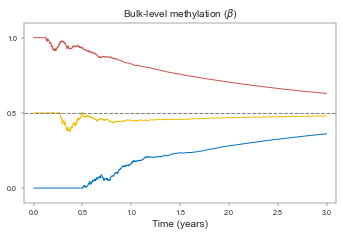

In [91]:
figsize = np.array([14, 8.3])

plot_data = pd.melt(pd.DataFrame(np.array(beta_list)).T.reset_index(), ['index'])
plot_data['Year'] = plot_data['index'] / 365
color_list = [consts['palette_jco'][i] for i in [0, 1, 3]]


fig, ax = plt.subplots(figsize=figsize * sf)

plot = sns.lineplot(ax=ax, x='Year', y='value', data=plot_data,
                    hue='variable',
                    palette=color_list, linestyle='solid', linewidth=2.5 * sf)

xlim = (-0.1, nyears + 0.1)

ax.set_ylim((-0.1, 1.1))
ax.set_yticks([0, 0.5, 1])
ax.set_title('Bulk-level methylation ($β$)', fontsize=labelfontsize * sf)
ax.set_ylabel('')
# ax.yaxis.set_label_coords(0.0, 1.07)
ax.set_xlabel('Time (years)', fontsize=labelfontsize * sf)
ax.legend('', frameon=False)

line_x = np.linspace(xlim[0], xlim[1], 100)
line_y = [0.5] * 100
ax.plot(line_x, line_y, color="grey", linestyle='dashed', linewidth=1.0)

ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(xlim)

fig.savefig(os.path.join(figure_outdir, 'simulation_3_sites.pdf'), format='pdf', pad_inches=0.1)

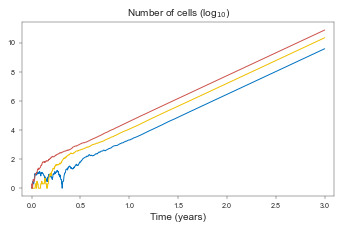

In [93]:
figsize = np.array([14, 8])

plot_data = pd.melt(pd.DataFrame(np.array(n_cells_list)).T.reset_index(), ['index'])
plot_data['value'] = np.log10(plot_data['value'])
plot_data['Year'] = plot_data['index'] / 365
color_list = [consts['palette_jco'][i] for i in [0, 1, 3]]


fig, ax = plt.subplots(figsize=figsize * sf)

plot = sns.lineplot(ax=ax, x='Year', y='value', data=plot_data,
                    hue='variable',
                    palette=color_list, linestyle='solid', linewidth=2.5 * sf)

xlim = (-0.1, nyears + 0.1)

ax.set_title('Number of cells (log$_{10}$)', fontsize=labelfontsize * sf)
ax.set_ylabel('')
# ax.yaxis.set_label_coords(0.0, 1.07)
ax.set_xlabel('Time (years)', fontsize=labelfontsize * sf)
ax.legend('', frameon=False)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(xlim)

fig.savefig(os.path.join(figure_outdir, 'simulation_3_sites_n_cells.pdf'), format='pdf', pad_inches=0.1)

In [8]:
N_FLIPS = 0

init_params = {'n_CpGs':500, 'n_cells':1,
#                'flip_rate':FLIP_RATE, # flip rate per cell division per allele
#                'growth_rate':GROWTH_RATE, # cell divisions per day
#                'death_rate':DEATH_RATE, # cell deaths per day,
               'flip_rate':0, # flip rate per cell division per allele
               'growth_rate':0.02, # cell divisions per day
               'death_rate':0, # cell deaths per day,
#                'init_site_state_probs':[0.25, 0.25, 0.25, 0.25],
               'init_site_state_probs':[1, 0, 0, 0],
              }
gen = np.random.default_rng()

nyears = 2

total_days = int(nyears * 365)
beta_values_list = [[] for site in range(init_params['n_CpGs'])]
cell_counts_avg = np.zeros(4)
count_first = []
for site in range(init_params['n_CpGs']):
    cell_counts = initCells(init_params, gen)

    for i in range(total_days):
        passDay(cell_counts, init_params, gen)
        beta_values_list[site].append(getBetaValue(cell_counts))
    
    cell_counts_avg += cell_counts
    count_first.append(cell_counts[0])

cell_counts_avg /= init_params['n_CpGs']

beta_values_arr = np.array(beta_values_list)
print(np.mean(beta_values_arr[:, -1]))
n_flips = -np.log(1 - 2 * np.mean(beta_values_arr[:, -1])) / 2
print(n_flips)
age_in_days = n_flips / (init_params['growth_rate'] * init_params['flip_rate'])
print(age_in_days)
print(age_in_days / 365)

# print(cell_counts_avg)

0.0
-0.0
nan
nan


/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_5839/2325366537.py:37: RuntimeWarning: invalid value encountered in scalar divide
  age_in_days = n_flips / (init_params['growth_rate'] * init_params['flip_rate'])


In [94]:
nyears = 3

init_params = {'n_CpGs':100, 'n_cells':1,
               'flip_rate':FLIP_RATE, # flip rate per cell division per allele
               'growth_rate':GROWTH_RATE, # cell divisions per day
               'death_rate':DEATH_RATE, # cell deaths per day,
               'init_site_state_probs':[0, 0, 0, 0],
}

gen = np.random.default_rng(seed)
total_days = int(nyears * 365)

cell_count_list = []
for j in [0, 1, 3]:
    init_params['init_site_state_probs'][j] = 1
    for k in range(init_params['n_CpGs']):
        cell_count_list.append(initCells(init_params, gen))
    init_params['init_site_state_probs'][j] = 0

beta_values_list = [[] for jk in range(3 * init_params['n_CpGs'])]

for i in range(total_days+1):
    for jk in range(len(beta_values_list)):
        beta_values_list[jk].append(getBetaValue(cell_count_list[jk]))
        passDay(cell_count_list[jk], init_params, gen)

beta_values_arr = np.array(beta_values_list)

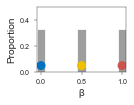

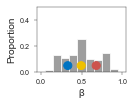

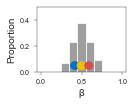

In [95]:
figsize = np.array([4, 3])

time_checkpoints = [0, int(total_days/2), total_days]
color_list = [consts['palette_jco'][i] for i in [0, 1, 3]]

k = 0
for chk in time_checkpoints:
    fig, ax = plt.subplots(figsize=figsize * sf)
    
    plotBetaValues(ax, beta_values=beta_values_arr[:, chk],
                   binwidth=0.1, color=consts['palette_jco'][2], opacity=opacity,
                   labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, bins=np.linspace(-0.05, 1.05, 12))
    ax.set_ylim(0, 0.5)
    
    for j in range(3):
#         beta = beta_values_arr[j * init_params['n_CpGs'], chk]     # Individual representative site
        beta = np.mean(beta_values_arr[j*init_params['n_CpGs']:(j+1)*init_params['n_CpGs'], chk])     # Mean of sites in group
        y_height = ax.get_ylim()[1]
        ax.add_patch(Ellipse((beta, y_height/10), 0.25 * sf, 0.3*y_height * sf, color=color_list[j]))
    
    fig.savefig(os.path.join(figure_outdir, f'simulation_300_sites_hist_{k}.pdf'), format='pdf', pad_inches=0.1)
    
    k += 1

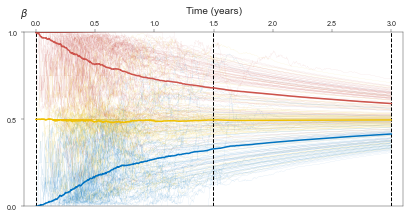

In [96]:
figsize = np.array([17, 8])

data_list = []
for j in range(3):
    data = pd.melt(pd.DataFrame(
        beta_values_arr[j*init_params['n_CpGs']:(j+1)*init_params['n_CpGs']]
    ).T.reset_index(), ['index'])
    data['Year'] = data['index'] / 365
    data['variable'] += init_params['n_CpGs'] * j
    data_list.append(data)

plot_data = pd.concat(data_list, axis=0)

# palette = ['gray']*(3*init_params['n_CpGs'])
# for j in range(3):
#     palette[j*init_params['n_CpGs']] = color_list[j]

palette = np.concatenate([[color]*init_params['n_CpGs'] for color in color_list]).tolist()

fig, ax = plt.subplots(figsize=figsize * sf)

plot = sns.lineplot(ax=ax, x='Year', y='value', data=plot_data,
                    hue='variable', palette=palette,
                    linestyle='solid', linewidth=0.2 * sf, alpha=0.5
                   )
xlim = (-0.1, nyears + 0.1)

ax.set_ylim(0, 1)
ax.set_xlim(xlim)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labeltop=True)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('$β$', rotation=0, fontsize=labelfontsize * sf)
ax.yaxis.set_label_coords(0.0, 1.07)
ax.set_xlabel('Time (years)', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, 1.15)
ax.legend('', frameon=False)

for t in time_checkpoints:
    ax.axvline(x = t / 365, linestyle='dashed', color='black', linewidth=2.5 * sf)
    
for j in range(3):
    plot_data_group_j = plot_data.loc[(plot_data['variable'] >= j*init_params['n_CpGs']) & (plot_data['variable'] < (j+1)*init_params['n_CpGs'])]
    mean_beta_ser = plot_data_group_j.groupby('Year')['value'].agg('mean')
    ax.plot(mean_beta_ser.index, mean_beta_ser, color=color_list[j])

fig.savefig(os.path.join(figure_outdir, 'simulation_300_sites.pdf'), format='pdf', pad_inches=0.1)

In [199]:
nyears = 3
init_params = {'n_CpGs':500, 'n_cells':1,
               'flip_rate':FLIP_RATE, # flip rate per cell division per allele
               'growth_rate':GROWTH_RATE, # cell divisions per day
               'death_rate':DEATH_RATE, # cell deaths per day,
               'init_site_state_probs':[2/5, 1/5, 0, 2/5],
}

gen = np.random.default_rng()
total_days = int(nyears * 365)

beta_values_list = [[] for k in range(init_params['n_CpGs'])]

site_list = []
for k in range(init_params['n_CpGs']):
    site_list.append(Site(copy.deepcopy(init_params), gen))
    

for i in range(total_days+1):
    if i % 100 == 0:
        print(i)
    for k in range(init_params['n_CpGs']):
        beta_values_list[k].append(getBetaValue(site_list[k].cell_counts))
        passDay(site_list[k].cell_counts, init_params, gen)

beta_values_arr = np.array(beta_values)

c_beta_at_time = 1 - np.std(beta_values_arr, axis=0)
# sns.lineplot(c_beta_at_time)

delta_t = 7
delt_c_beta = c_beta_at_time[delta_t:] - c_beta_at_time[:-delta_t]
sns.lineplot(delt_c_beta)
plt.axhline(0)

0
100
200
300
400
500
600
700
800
900
1000


In [101]:
init_params = {'n_CpGs':1, 'n_cells':1,
               'flip_rate':FLIP_RATE, # flip rate per cell division per allele
               'growth_rate':GROWTH_RATE, # cell divisions per day
               'death_rate':DEATH_RATE, # cell deaths per day,
               'init_site_state_probs':[1, 0, 0, 0],
              }
gen = np.random.default_rng(seed)

site_list = [Site(copy.deepcopy(init_params), gen)]

slower_init_params = init_params.copy()
slower_init_params['death_rate'] = (slower_init_params['growth_rate'] + slower_init_params['death_rate']) / 2
site_list.append(Site(slower_init_params, gen))

n_cells_list = [[], []]

for j in range(2):
    i = k = 0
    while True:
        if k == 1e9:
            sys.exit()

        n_cells = np.sum(site_list[j].cell_counts)
        n_cells_list[j].append(n_cells)

        if n_cells > 1e9:
            break
        
        if passDay(site_list[j].cell_counts, site_list[j].init_params, gen):
            i += 1
        else:   # restart simulation
            i = 0
            site_list[j].reInit()
            n_cells_list[j].clear()

        k += 1


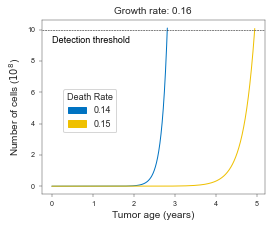

In [124]:
figsize = np.array([10, 8])

scale = 10**8

plot_data = pd.concat([pd.DataFrame({'n_cells':n_cells_list[j], 'Death Rate':round(site_list[j].init_params['death_rate'], 2)}) for j in range(2)], axis=0).reset_index()
plot_data['Year'] = plot_data['index'] / 365
plot_data['n_cells'] /= scale
color_list = [consts['palette_jco'][i] for i in [0, 1]]
color_dict = dict(zip(plot_data['Death Rate'].unique(), color_list))

fig, ax = plt.subplots(figsize=figsize * sf)

plot = sns.lineplot(ax=ax, x='Year', y='n_cells', data=plot_data,
                    hue='Death Rate', legend=False,
                    palette=color_dict, linestyle='solid', linewidth=2.5 * sf)

xlim = (-0.1, nyears + 0.1)

ax.set_title(f'Growth rate: {site_list[0].init_params["growth_rate"]}', fontsize=labelfontsize * sf)
ax.set_ylabel(f'Number of cells ($10^{int(np.log10(scale))}$)', fontsize=labelfontsize * sf)
ax.set_xlabel('Tumor age (years)', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
leg = fig.legend(
    title = 'Death Rate',
    handles=patches,
    loc='upper right',
    bbox_to_anchor=(0.4, 0.6),
    fontsize=0.9*labelfontsize * sf,
)

leg.get_title().set_fontsize(0.9*labelfontsize * sf)

ax.axhline(y=10, ls='--', lw=0.5, color='black')
ax.text(0, 9, 'Detection threshold',
        ha="left", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=labelfontsize * 0.9 * sf)

fig.savefig(os.path.join(figure_outdir, 'simulation_different_death_rates.pdf'), format='pdf', pad_inches=0.1)